In [15]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [16]:
# Database Reading and Manipulation
import pandas as pd
import tensorflow as tf

# Random and os for reproducibility
import random
import os

# Linear Algebra
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
from sklearn.linear_model import LinearRegression

# Processing
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Pipeline
from sklearn.pipeline import Pipeline

<IPython.core.display.Javascript object>

# Functions and definitions

In [17]:
def score_model(model, x, y, n_splits=10, n_repeats=10):
    scoring = "neg_root_mean_squared_error"
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=SEED)
    scores = cross_val_score(model, x, y, scoring=scoring, cv=cv, n_jobs=-1)
    return scores

<IPython.core.display.Javascript object>

In [18]:
def plot_predictions(linreg_model, df, index, x, y):
    d = df["Data/Hora"].values
    test_series = pd.DataFrame({"ccs28": y}, index=pd.to_datetime(d))
    pred_series = linreg_model.predict(scaler.transform(x))
    pred_series = pd.DataFrame({"ccs28-pred": pred_series}, index=pd.to_datetime(d))

    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15, 7))

    test_series.plot(ax=ax)
    ax.axvline(test_series.index[index], color="r")  # end of train dataset
    pred_series[index:].plot(ax=ax)
    ax.grid(which="both")
    ax.legend(
        ["train and test series", "end of train series", "predicted"], loc="upper left"
    )
    # ax.set_xlabel('Period', labelpad=20, fontsize=15)
    ax.set_ylabel("Compressive Strength - MPa", labelpad=20, fontsize=15)
    plt.show()

<IPython.core.display.Javascript object>

In [19]:
def plot_scores_box_plot(scores, repeats, n_splits):
    plt.figure(figsize=(15, 8))
    plt.boxplot(
        scores.reshape((repeats, n_splits)),
        labels=[str(r) for r in range(1, repeats + 1)],
        showmeans=True,
    )
    plt.ylabel("RMSE", labelpad=20, fontsize=15)
    plt.xlabel("Repeats", labelpad=20, fontsize=15)
    plt.show()

<IPython.core.display.Javascript object>

In [20]:
class BlockingTimeSeriesSplit:
    def __init__(self, n_splits):
        self.n_splits = n_splits

    def get_n_splits(self, X, y, groups):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.5 * (stop - start)) + start
            yield indices[start:mid], indices[mid + margin : stop]


# Reference: https://goldinlocks.github.io/Time-Series-Cross-Validation/

<IPython.core.display.Javascript object>

In [21]:
def repeated_blocking_time_series(
    Estimator, Transform, x, y, train_period, test_period, repeats=10, params=None
):
    results = []
    max_samples = x.shape[0]

    for _ in range(repeats):
        i = 0
        scores = []
        for _ in range(0, max_samples // (train_period + test_period)):
            scaler = Transform()
            model = Estimator() if params is None else Estimator(**params)
            x_train = x[i : i + train_period]
            y_train = y[i : i + train_period]
            x_test = x[i + train_period : i + train_period + test_period]
            y_test = y[i + train_period : i + train_period + test_period]
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)

            model.fit(x_train, y_train)

            y_train_pred = model.predict(x_train)
            y_test_pred = model.predict(x_test)
            scores.append(
                score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
            )
            i += train_period + test_period

        scores_final = {key: [] for key, _ in scores[0].items()}
        for scores_dict in scores:
            for key, value in scores_dict.items():
                scores_final[key] += [value]
        results.append(scores_final)
    return results

<IPython.core.display.Javascript object>

In [22]:
def print_scores(scores, METRICS, METRICS_DICT):
    for phase in ["train", "test"]:
        print("******")
        print(f"[{phase.upper()}]")
        print("******")
        for metric in METRICS:
            name = METRICS_DICT[metric]
            print(
                f"{name}: %.3f (%.3f)"
                % (
                    np.abs(np.mean(scores[f"{phase}_" + metric])),
                    np.std(scores[f"{phase}_" + metric]),
                )
            )
        print("\n======================\n")

<IPython.core.display.Javascript object>

In [23]:
def score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred):
    TRAIN_RMSE = mean_squared_error(y_true=y_train, y_pred=y_train_pred, squared=False)
    TRAIN_MAE = mean_absolute_error(y_true=y_train, y_pred=y_train_pred)
    TRAIN_MAPE = mean_absolute_percentage_error(y_true=y_train, y_pred=y_train_pred)
    TRAIN_R2 = r2_score(y_true=y_train, y_pred=y_train_pred)

    TEST_RMSE = mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False)
    TEST_MAE = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
    TEST_MAPE = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)
    TEST_R2 = r2_score(y_true=y_test, y_pred=y_test_pred)

    scores = {
        "train_neg_root_mean_squared_error": TRAIN_RMSE,
        "train_neg_mean_absolute_error": TRAIN_MAE,
        "train_neg_mean_absolute_percentage_error": TRAIN_MAPE,
        "train_r2": TRAIN_R2,
        "test_neg_root_mean_squared_error": TEST_RMSE,
        "test_neg_mean_absolute_error": TEST_MAE,
        "test_neg_mean_absolute_percentage_error": TEST_MAPE,
        "test_r2": TEST_R2,
    }
    return scores

<IPython.core.display.Javascript object>

In [24]:
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=256, activation="relu")),
    model.add(tf.keras.layers.Dense(units=128, activation="relu")),
    model.add(tf.keras.layers.Dense(units=64, activation="relu")),
    model.add(tf.keras.layers.Dense(units=32, activation="relu")),
    model.add(tf.keras.layers.Dense(units=16, activation="relu")),
    model.add(tf.keras.layers.Dropout(rate=0.10))
    model.add(tf.keras.layers.Dense(units=1))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
    )
    return model

<IPython.core.display.Javascript object>

# Settings for Reproducibility

In [25]:
def set_seeds():
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    os.environ["PYTHONHASHSEED"] = str(SEED)
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

<IPython.core.display.Javascript object>

In [26]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

# Baseline Model

# 1. Linear Regression

# Intercement

In [29]:
df = pd.read_csv("../../../../data/processed/Intercement/cement-shipping.csv")

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered.

In [30]:
df_no_cs = df.drop(
    [
        "RC1",
        "RC3",
        "RC7",
    ],
    axis=1,
).copy()

y = df_no_cs.pop("RC28").values
x = df_no_cs.drop(["Data"], axis=1)

<IPython.core.display.Javascript object>

## 1.1 Repeated KFold Cross validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Repeats:</b>10<br>
<b>Splits:</b>10<br>
    1. 10 folds of 123 samples each
    2. 90% train (1111 samples each fold)
    3. 10% test (123 samples each fold)
<b>Total:</b> 100 models<br>

In [31]:
set_seeds()
repeats = 10
n_splits = 10
pipeline = Pipeline(
    [("transformer", StandardScaler()), ("estimator", LinearRegression())]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
# scores = np.abs(scores)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

Repeated Cross Validation:
Repeats: 10
n_splits: 10

******
[TRAIN]
******
RMSE: 3.769 (0.037)
MAE: 2.892 (0.021)
MAPE: 0.063 (0.001)
R2: 0.706 (0.006)


******
[TEST]
******
RMSE: 3.803 (0.326)
MAE: 2.904 (0.087)
MAPE: 0.063 (0.002)
R2: 0.697 (0.055)




<IPython.core.display.Javascript object>

# partner_iii

In [34]:
df_partner_iii = pd.read_csv(
    "../../../../data/interim/partner_iii/Dati CADD 2020-2022_with_fillna.csv"
)

<IPython.core.display.Javascript object>

In [35]:
y = df_partner_iii.pop("28d compressive strength (MPa)").values
x = df_partner_iii.values

<IPython.core.display.Javascript object>

In [36]:
set_seeds()
repeats = 10
n_splits = 10
pipeline = Pipeline(
    [("transformer", StandardScaler()), ("estimator", LinearRegression())]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
# scores = np.abs(scores)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

Repeated Cross Validation:
Repeats: 10
n_splits: 10

******
[TRAIN]
******
RMSE: 5.137 (0.055)
MAE: 3.990 (0.047)
MAPE: 0.079 (0.001)
R2: 0.463 (0.014)


******
[TEST]
******
RMSE: 5.165 (0.490)
MAE: 4.030 (0.426)
MAPE: 0.080 (0.009)
R2: 0.417 (0.145)




<IPython.core.display.Javascript object>

# partner_ii

In [38]:
df = pd.read_csv("../../../../data/processed/partner_ii/cement-shipping.csv")
df_no_cs = df.drop(
    ["strength_1d", "strength_3d", "strength_7d"],
    axis=1,
).copy()

y = df_no_cs.pop("strength_28d").values
x = df_no_cs.drop(["sample_date"], axis=1)

<IPython.core.display.Javascript object>

In [39]:
set_seeds()
repeats = 10
n_splits = 10
pipeline = Pipeline(
    [("transformer", StandardScaler()), ("estimator", LinearRegression())]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
# scores = np.abs(scores)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

Repeated Cross Validation:
Repeats: 10
n_splits: 10

******
[TRAIN]
******
RMSE: 2.195 (0.021)
MAE: 1.749 (0.016)
MAPE: 0.041 (0.000)
R2: 0.614 (0.007)


******
[TEST]
******
RMSE: 2.263 (0.207)
MAE: 1.787 (0.137)
MAPE: 0.042 (0.003)
R2: 0.580 (0.080)




<IPython.core.display.Javascript object>

# Transfer Learning - MLP

## Pre Trainning

In [40]:
batch_size = 32
epochs = 200
verbose = 0

<IPython.core.display.Javascript object>

# Intercement

In [43]:
df = pd.read_csv("../../../../data/processed/Intercement/cement-shipping.csv")
df_no_cs = df.drop(
    [
        "RC1",
        "RC3",
        "RC7",
    ],
    axis=1,
).copy()

y = df_no_cs.pop("RC28").values
x = df_no_cs.drop(["Data"], axis=1)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [44]:
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=32, activation="relu")),
    model.add(tf.keras.layers.Dense(units=16, activation="relu")),
    model.add(tf.keras.layers.Dropout(rate=0.10))
    model.add(tf.keras.layers.Dense(units=1))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
    )
    return model

<IPython.core.display.Javascript object>

In [45]:
set_seeds()
model = get_model()
sc = StandardScaler()
history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

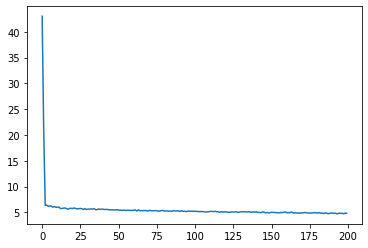

<IPython.core.display.Javascript object>

In [46]:
plt.plot(history.history["RMSE"])

In [47]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 3.191 (0.000)
MAE: 2.450 (0.000)
MAPE: 0.054 (0.000)
R2: 0.754 (0.000)


******
[TEST]
******
RMSE: 5.792 (0.000)
MAE: 4.762 (0.000)
MAPE: 0.088 (0.000)
R2: 0.009 (0.000)




<IPython.core.display.Javascript object>

In [48]:
model.evaluate(sc.transform(x_test), y_test)

35/35 [==============================] - 0s 725us/step - loss: 33.5454 - RMSE: 5.7918


[33.54537582397461, 5.791837215423584]

<IPython.core.display.Javascript object>

In [49]:
trained_layers = history.model.layers

<IPython.core.display.Javascript object>

In [50]:
trained_layers

<IPython.core.display.Javascript object>

# Fine Tuning

# partner_iii

In [53]:
df_partner_iii = pd.read_csv(
    "../../../../data/interim/partner_iii/Dati CADD 2020-2022_with_fillna.csv"
)

<IPython.core.display.Javascript object>

In [54]:
y = df_partner_iii.pop("28d compressive strength (MPa)").values
x = df_partner_iii.values

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [55]:
set_seeds()
model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Dense(units=32, activation="relu"))
trained_layers[1].trainable = False
model_2.add(trained_layers[1])
trained_layers[2].trainable = False
model_2.add(trained_layers[2])


model_2.add(tf.keras.layers.Dense(units=32, activation="relu"))
model_2.add(tf.keras.layers.Dense(units=16, activation="relu"))
model_2.add(tf.keras.layers.Dense(units=1))
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [56]:
# set_seeds()
# model_2 = tf.keras.Sequential()
# model_2.add(tf.keras.layers.Dense(units=256, activation="relu"))
# trained_layers[1].trainable = True
# model_2.add(trained_layers[1])
# trained_layers[2].trainable = True
# model_2.add(trained_layers[2])
# trained_layers[3].trainable = True
# model_2.add(trained_layers[3])
# trained_layers[4].trainable = True
# model_2.add(trained_layers[4])

# model_2.add(tf.keras.layers.Dense(units=32, activation="relu"))
# model_2.add(tf.keras.layers.Dense(units=16, activation="relu"))
# model_2.add(tf.keras.layers.Dense(units=32, activation="relu"))
# model_2.add(tf.keras.layers.Dense(units=1))
# model_2.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#     loss="mse",
#     metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
# )

<IPython.core.display.Javascript object>

In [58]:
sc = StandardScaler()
history = model_2.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=200,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

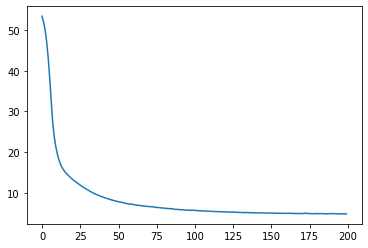

<IPython.core.display.Javascript object>

In [59]:
plt.plot(history.history["RMSE"])

In [60]:
y_train_pred = model_2.predict(sc.transform(x_train))
y_test_pred = model_2.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 4.806 (0.000)
MAE: 3.824 (0.000)
MAPE: 0.075 (0.000)
R2: 0.574 (0.000)


******
[TEST]
******
RMSE: 4.956 (0.000)
MAE: 3.471 (0.000)
MAPE: 0.070 (0.000)
R2: 0.160 (0.000)




<IPython.core.display.Javascript object>

# Pre Trainning

In [61]:
batch_size = 32
epochs = 200
verbose = 0

<IPython.core.display.Javascript object>

# partner_i

In [81]:
df_partner_i = pd.read_csv(
    "../../../../data/processed/partner_i-Oficial/cement-shipping.csv"
)

<IPython.core.display.Javascript object>

In [82]:
df_partner_i = df_partner_i.drop(
    [
        "1 day Compressive strength",
        "3 day Compressive strength",
        "7 day Compressive strength",
    ],
    axis=1,
).copy()

y = df_partner_i.pop("28 day Compressive strength").values
x = df_partner_i.drop(["Date"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [83]:
set_seeds()
model = get_model()
sc = StandardScaler()
history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

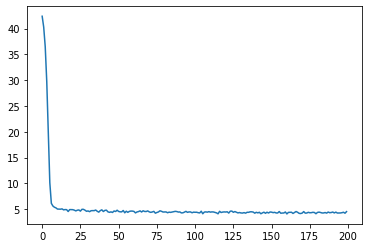

<IPython.core.display.Javascript object>

In [84]:
plt.plot(history.history["RMSE"])

In [85]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 1.119 (0.000)
MAE: 0.849 (0.000)
MAPE: 0.020 (0.000)
R2: 0.951 (0.000)


******
[TEST]
******
RMSE: 1.461 (0.000)
MAE: 1.073 (0.000)
MAPE: 0.024 (0.000)
R2: 0.914 (0.000)




<IPython.core.display.Javascript object>

In [86]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 32)                1216      
_________________________________________________________________
dense_19 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 17        
Total params: 1,761
Trainable params: 1,761
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

In [87]:
trained_layers = history.model.layers

<IPython.core.display.Javascript object>

In [88]:
trained_layers

<IPython.core.display.Javascript object>

# partner_iii

In [89]:
df_partner_iii = pd.read_csv(
    "../../../../data/interim/partner_iii/Dati CADD 2020-2022_with_fillna.csv"
)

<IPython.core.display.Javascript object>

In [90]:
y = df_partner_iii.pop("28d compressive strength (MPa)").values
x = df_partner_iii.values

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [91]:
set_seeds()
model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Dense(units=32, activation="relu"))
trained_layers[1].trainable = False
model_2.add(trained_layers[1])
trained_layers[2].trainable = False
model_2.add(trained_layers[2])

model_2.add(tf.keras.layers.Dense(units=32, activation="relu"))
model_2.add(tf.keras.layers.Dense(units=16, activation="relu"))
model_2.add(tf.keras.layers.Dense(units=1))
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [92]:
# set_seeds()
# model_2 = tf.keras.Sequential()
# model_2.add(tf.keras.layers.Dense(units=256, activation="relu"))
# trained_layers[1].trainable = True
# model_2.add(trained_layers[1])
# trained_layers[2].trainable = True
# model_2.add(trained_layers[2])
# trained_layers[3].trainable = True
# model_2.add(trained_layers[3])
# trained_layers[4].trainable = True
# model_2.add(trained_layers[4])

# model_2.add(tf.keras.layers.Dense(units=32, activation="relu"))
# model_2.add(tf.keras.layers.Dense(units=16, activation="relu"))
# model_2.add(tf.keras.layers.Dense(units=32, activation="relu"))
# model_2.add(tf.keras.layers.Dense(units=1))
# model_2.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#     loss="mse",
#     metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
# )

<IPython.core.display.Javascript object>

In [93]:
sc = StandardScaler()
history = model_2.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=500,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

In [94]:
y_train_pred = model_2.predict(sc.transform(x_train))
y_test_pred = model_2.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 5.679 (0.000)
MAE: 4.500 (0.000)
MAPE: 0.082 (0.000)
R2: 0.392 (0.000)


******
[TEST]
******
RMSE: 3.849 (0.000)
MAE: 3.176 (0.000)
MAPE: 0.059 (0.000)
R2: 0.014 (0.000)




<IPython.core.display.Javascript object>

In [95]:
trained_layers[0].get_config()

{'name': 'dense_18',
 'trainable': True,
 'dtype': 'float32',
 'units': 32,
 'activation': 'relu',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

<IPython.core.display.Javascript object>

# Pre Trainning

In [96]:
batch_size = 32
epochs = 200
verbose = 0

<IPython.core.display.Javascript object>

# partner_i

In [97]:
df_partner_i = pd.read_csv(
    "../../../../data/processed/partner_i-Oficial/cement-shipping.csv"
)

<IPython.core.display.Javascript object>

In [98]:
df_partner_i = df_partner_i.drop(
    [
        "1 day Compressive strength",
        "3 day Compressive strength",
        "7 day Compressive strength",
    ],
    axis=1,
).copy()

y = df_partner_i.pop("28 day Compressive strength").values
x = df_partner_i.drop(["Date"], axis=1).values

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [99]:
set_seeds()
model = get_model()
sc = StandardScaler()
history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

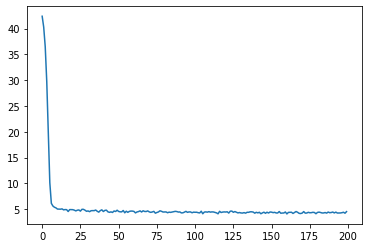

<IPython.core.display.Javascript object>

In [100]:
plt.plot(history.history["RMSE"])

In [101]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 1.119 (0.000)
MAE: 0.849 (0.000)
MAPE: 0.020 (0.000)
R2: 0.951 (0.000)


******
[TEST]
******
RMSE: 1.461 (0.000)
MAE: 1.073 (0.000)
MAPE: 0.024 (0.000)
R2: 0.914 (0.000)




<IPython.core.display.Javascript object>

In [102]:
trained_layers = history.model.layers

<IPython.core.display.Javascript object>

In [103]:
trained_layers

<IPython.core.display.Javascript object>

# Fine Tuning

# Intercement

In [105]:
df = pd.read_csv("../../../../data/processed/Intercement/cement-shipping.csv")
df_no_cs = df.drop(
    [
        "RC1",
        "RC3",
        "RC7",
    ],
    axis=1,
).copy()

y = df_no_cs.pop("RC28").values
x = df_no_cs.drop(["Data"], axis=1).values
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [106]:
set_seeds()
model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Dense(units=32, activation="relu"))
trained_layers[1].trainable = True
model_2.add(trained_layers[1])
trained_layers[2].trainable = True
model_2.add(trained_layers[2])
# trained_layers[3].trainable = True
# model_2.add(trained_layers[3])
# trained_layers[4].trainable = True
# model_2.add(trained_layers[4])

model_2.add(tf.keras.layers.Dense(units=32, activation="relu"))
model_2.add(tf.keras.layers.Dense(units=16, activation="relu"))
model_2.add(tf.keras.layers.Dense(units=1))
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [107]:
sc = StandardScaler()
history = model_2.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

In [108]:
y_test_pred.shape

(247, 1)

<IPython.core.display.Javascript object>

In [109]:
y_train_pred = model_2.predict(sc.transform(x_train))
y_test_pred = model_2.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 4.702 (0.000)
MAE: 4.057 (0.000)
MAPE: 0.085 (0.000)
R2: 0.466 (0.000)


******
[TEST]
******
RMSE: 8.868 (0.000)
MAE: 7.825 (0.000)
MAPE: 0.144 (0.000)
R2: 1.323 (0.000)




<IPython.core.display.Javascript object>

In [62]:
y_train_pred = model_2.predict(sc.transform(x_train))
y_test_pred = model_2.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 2.446 (0.000)
MAE: 1.829 (0.000)
MAPE: 0.041 (0.000)
R2: 0.855 (0.000)


******
[TEST]
******
RMSE: 4.394 (0.000)
MAE: 3.636 (0.000)
MAPE: 0.067 (0.000)
R2: 0.430 (0.000)




<IPython.core.display.Javascript object>

# Experiments with same variables

In [110]:
def get_model(shape, include_top=True):
    inputs = tf.keras.Input(shape=shape)
    x = tf.keras.layers.Dense(units=256, activation="relu")(inputs)
    x = tf.keras.layers.Dense(units=128, activation="relu")(x)
    x = tf.keras.layers.Dense(units=64, activation="relu")(x)
    x = tf.keras.layers.Dense(units=32, activation="relu")(x)
    x = tf.keras.layers.Dense(units=16, activation="relu")(x)
    if include_top:
        x = tf.keras.layers.Dropout(0.1)(x)
        outputs = tf.keras.layers.Dense(units=1)(x)
        model = tf.keras.Model(inputs, outputs)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
        )
    else:
        model = tf.keras.Model(inputs, x)
    return model

<IPython.core.display.Javascript object>

In [121]:
def get_model(shape, include_top=True):
    inputs = tf.keras.Input(shape=shape)
    x = tf.keras.layers.Dense(units=32, activation="relu")(inputs)
    x = tf.keras.layers.Dense(units=16, activation="relu")(x)

    if include_top:
        x = tf.keras.layers.Dropout(0.1)(x)
        outputs = tf.keras.layers.Dense(units=1)(x)
        model = tf.keras.Model(inputs, outputs)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
        )
    else:
        model = tf.keras.Model(inputs, x)
    return model

<IPython.core.display.Javascript object>

# Pre Trainning

# partner_i

In [135]:
batch_size = 32
epochs = 200
verbose = 0

<IPython.core.display.Javascript object>

In [136]:
COMMON_FEATURES = ["mgo", "al2o3", "sio2", "so3", "k2o", "fe2o3"]

<IPython.core.display.Javascript object>

In [137]:
df_partner_i = pd.read_csv(
    "../../../../data/processed/partner_i-Oficial/cement-shipping.csv"
)

<IPython.core.display.Javascript object>

In [138]:
df_partner_i = df_partner_i.drop(
    [
        "1 day Compressive strength",
        "3 day Compressive strength",
        "7 day Compressive strength",
    ],
    axis=1,
).copy()

y = df_partner_i.pop("28 day Compressive strength")
x = df_partner_i.drop(["Date"], axis=1)
x.columns = x.columns.str.lower()
x = x[COMMON_FEATURES]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [139]:
set_seeds()

model = get_model(shape=(x_train.shape[-1]))
sc = StandardScaler()

history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

In [140]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 3.623 (0.000)
MAE: 2.850 (0.000)
MAPE: 0.068 (0.000)
R2: 0.485 (0.000)


******
[TEST]
******
RMSE: 3.410 (0.000)
MAE: 2.849 (0.000)
MAPE: 0.066 (0.000)
R2: 0.529 (0.000)




<IPython.core.display.Javascript object>

In [141]:
model.save_weights("conv1d_weights.h5")

<IPython.core.display.Javascript object>

# Fine Tuning

# partner_iii

In [128]:
df_partner_iii = pd.read_csv(
    "../../../../data/interim/partner_iii/Dati CADD 2020-2022_with_fillna.csv"
)

<IPython.core.display.Javascript object>

In [129]:
y = df_partner_iii.pop("28d compressive strength (MPa)")
x = df_partner_iii

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [130]:
set_seeds()

model_2 = get_model(include_top=False, shape=(x.shape[-1]))
model_2.load_weights("conv1d_weights.h5", by_name=True)
model_2.trainable = True

flat1 = tf.keras.layers.Flatten(name="Flatten2")(model_2.layers[-1].output)
class1 = tf.keras.layers.Dense(256, activation="relu")(flat1)
outputs = tf.keras.layers.Dense(1, activation="linear")(class1)
model = tf.keras.Model(model_2.inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [132]:
sc = StandardScaler()
history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

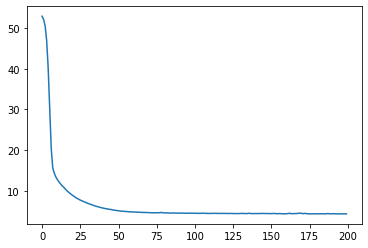

<IPython.core.display.Javascript object>

In [133]:
plt.plot(history.history["RMSE"])

In [134]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 4.268 (0.000)
MAE: 3.286 (0.000)
MAPE: 0.063 (0.000)
R2: 0.656 (0.000)


******
[TEST]
******
RMSE: 3.857 (0.000)
MAE: 2.746 (0.000)
MAPE: 0.054 (0.000)
R2: 0.018 (0.000)




<IPython.core.display.Javascript object>

# Intercement

In [142]:
df = pd.read_csv("../../../../data/processed/Intercement/cement-shipping.csv")
df_no_cs = df.drop(
    [
        "RC1",
        "RC3",
        "RC7",
    ],
    axis=1,
).copy()

y = df_no_cs.pop("RC28")
x = df_no_cs.drop(["Data"], axis=1)
x.columns = x.columns.str.lower()
x = x[COMMON_FEATURES]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [178]:
set_seeds()

model_2 = get_model(include_top=False, shape=(x.shape[-1]))
model_2.load_weights("conv1d_weights.h5", by_name=True)
model_2.trainable = False

flat1 = tf.keras.layers.Flatten()(model_2.layers[-1].output)
class1 = tf.keras.layers.Dense(32, activation="relu")(flat1)
# class1 = tf.keras.layers.Dense(16, activation="relu")(class1)
outputs = tf.keras.layers.Dense(1, activation="linear")(class1)
# model = tf.keras.Model(model_2.inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    # loss=tf.keras.losses.Huber(),
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [179]:
# sc = StandardScaler()

history = model.fit(
    sc.transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

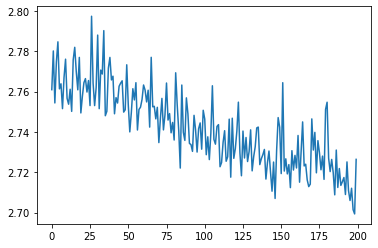

<IPython.core.display.Javascript object>

In [180]:
plt.plot(history.history["RMSE"])

In [181]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 2.700 (0.000)
MAE: 2.019 (0.000)
MAPE: 0.044 (0.000)
R2: 0.824 (0.000)


******
[TEST]
******
RMSE: 16.548 (0.000)
MAE: 8.034 (0.000)
MAPE: 0.148 (0.000)
R2: 7.088 (0.000)




<IPython.core.display.Javascript object>

# Pre Trainning

In [195]:
batch_size = 32
epochs = 200
verbose = 0

<IPython.core.display.Javascript object>

# partner_i + partner_ii

In [196]:
batch_size = 32
epochs = 200
verbose = 1

<IPython.core.display.Javascript object>

In [197]:
COMMON_FEATURES = ["mgo", "al2o3", "sio2", "so3", "k2o", "fe2o3"]

<IPython.core.display.Javascript object>

In [198]:
df_partner_ii = pd.read_csv("../../../../data/processed/partner_ii/cement-shipping.csv")
df_no_cs = df_partner_ii.drop(
    ["strength_1d", "strength_3d", "strength_7d"],
    axis=1,
).copy()
y_1 = df_no_cs.pop("strength_28d")
x_1 = df_no_cs.rename({"sample_date": "date"}, axis=1)

df_partner_i = pd.read_csv(
    "../../../../data/processed/partner_i-Oficial/cement-shipping.csv"
)
df_partner_i = df_partner_i.drop(
    [
        "1 day Compressive strength",
        "3 day Compressive strength",
        "7 day Compressive strength",
    ],
    axis=1,
).copy()

y_2 = df_partner_i.pop("28 day Compressive strength")
x_2 = df_partner_i

x_2.columns = x_2.columns.str.lower()
x_2 = x_2.drop(set(x_2.columns) - set(x_1.columns), axis=1)
x_1 = x_1[x_2.columns]


y_1.name = "cs28"
y_2.name = "cs28"

x = pd.concat([x_1, x_2], axis=0).reset_index(drop=True)
y = pd.concat([y_1, y_2], axis=0).reset_index(drop=True)

x = pd.concat([x, y], axis=1)
x["date"] = x["date"].apply(lambda x: x[:10])
x["date"] = pd.to_datetime(x["date"])
x = x.sort_values(by="date").reset_index(drop=True)
y = x.pop("cs28")
x.columns = x.columns.str.lower()
x = x[COMMON_FEATURES]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [187]:
set_seeds()
model = get_model(shape=(x_train.shape[-1]))
sc = StandardScaler()

history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

Epoch 1/200
58/58 [==============================] - 0s 1ms/step - loss: 1866.6179 - RMSE: 43.2044
Epoch 2/200
58/58 [==============================] - 0s 2ms/step - loss: 1715.8634 - RMSE: 41.4230
Epoch 3/200
58/58 [==============================] - 0s 1ms/step - loss: 1317.7567 - RMSE: 36.3009
Epoch 4/200
58/58 [==============================] - 0s 2ms/step - loss: 658.6940 - RMSE: 25.6650
Epoch 5/200
58/58 [==============================] - 0s 2ms/step - loss: 154.1264 - RMSE: 12.4148
Epoch 6/200
58/58 [==============================] - 0s 1ms/step - loss: 39.3001 - RMSE: 6.2690
Epoch 7/200
58/58 [==============================] - 0s 3ms/step - loss: 36.9313 - RMSE: 6.0771
Epoch 8/200
58/58 [==============================] - 0s 2ms/step - loss: 39.0025 - RMSE: 6.2452
Epoch 9/200
58/58 [==============================] - 0s 2ms/step - loss: 38.3857 - RMSE: 6.1956
Epoch 10/200
58/58 [==============================] - 0s 2ms/step - loss: 38.1059 - RMSE: 6.1730
Epoch 11/200
58/58 [======

58/58 [==============================] - 0s 2ms/step - loss: 36.1148 - RMSE: 6.0096
Epoch 86/200
58/58 [==============================] - 0s 2ms/step - loss: 34.8254 - RMSE: 5.9013
Epoch 87/200
58/58 [==============================] - 0s 3ms/step - loss: 33.0511 - RMSE: 5.7490
Epoch 88/200
58/58 [==============================] - 0s 3ms/step - loss: 35.6347 - RMSE: 5.9695
Epoch 89/200
58/58 [==============================] - 0s 2ms/step - loss: 36.0425 - RMSE: 6.0035
Epoch 90/200
58/58 [==============================] - 0s 2ms/step - loss: 34.0450 - RMSE: 5.8348
Epoch 91/200
58/58 [==============================] - 0s 3ms/step - loss: 35.4912 - RMSE: 5.9574
Epoch 92/200
58/58 [==============================] - 0s 3ms/step - loss: 35.8376 - RMSE: 5.9865
Epoch 93/200
58/58 [==============================] - 0s 1ms/step - loss: 35.1266 - RMSE: 5.9268
Epoch 94/200
58/58 [==============================] - 0s 1ms/step - loss: 36.3541 - RMSE: 6.0294
Epoch 95/200
58/58 [=======================

58/58 [==============================] - 0s 2ms/step - loss: 31.2457 - RMSE: 5.5898
Epoch 169/200
58/58 [==============================] - 0s 2ms/step - loss: 31.7243 - RMSE: 5.6324
Epoch 170/200
58/58 [==============================] - 0s 3ms/step - loss: 32.1983 - RMSE: 5.6744
Epoch 171/200
58/58 [==============================] - 0s 5ms/step - loss: 31.3704 - RMSE: 5.6009
Epoch 172/200
58/58 [==============================] - 0s 3ms/step - loss: 32.0003 - RMSE: 5.6569
Epoch 173/200
58/58 [==============================] - 0s 3ms/step - loss: 32.9404 - RMSE: 5.7394
Epoch 174/200
58/58 [==============================] - 0s 3ms/step - loss: 29.9606 - RMSE: 5.4736
Epoch 175/200
58/58 [==============================] - 0s 3ms/step - loss: 32.3400 - RMSE: 5.6868
Epoch 176/200
58/58 [==============================] - 0s 2ms/step - loss: 31.6836 - RMSE: 5.6288
Epoch 177/200
58/58 [==============================] - 0s 3ms/step - loss: 32.7002 - RMSE: 5.7184
Epoch 178/200
58/58 [=============

<IPython.core.display.Javascript object>

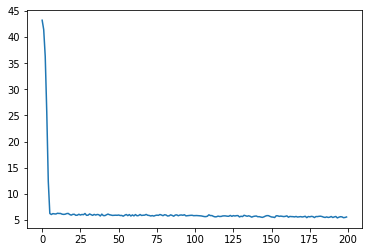

<IPython.core.display.Javascript object>

In [188]:
plt.plot(history.history["RMSE"])

In [189]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))
scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 3.363 (0.000)
MAE: 2.675 (0.000)
MAPE: 0.062 (0.000)
R2: 0.382 (0.000)


******
[TEST]
******
RMSE: 3.865 (0.000)
MAE: 3.349 (0.000)
MAPE: 0.082 (0.000)
R2: 0.352 (0.000)




<IPython.core.display.Javascript object>

In [199]:
model.save_weights("conv1d_weights.h5")

<IPython.core.display.Javascript object>

# Fine Tuning

# partner_iii

In [89]:
df_partner_iii = pd.read_csv(
    "../../../data/interim/partner_iii/Dati CADD 2020-2022_with_fillna.csv"
)

<IPython.core.display.Javascript object>

In [90]:
y = df_partner_iii.pop("28d compressive strength (MPa)")
x = df_partner_iii

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [190]:
set_seeds()

model_2 = get_model(include_top=False, shape=(x.shape[-1]))
model_2.load_weights("conv1d_weights.h5", by_name=True)
model_2.trainable = True

flat1 = tf.keras.layers.Flatten(name="Flatten2")(model_2.layers[-1].output)
class1 = tf.keras.layers.Dense(256, activation="relu")(flat1)
outputs = tf.keras.layers.Dense(1, activation="linear")(class1)
model = tf.keras.Model(model_2.inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # loss="mse",
    loss=tf.keras.losses.Huber(),
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [191]:
sc = StandardScaler()
history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

Epoch 1/200
58/58 [==============================] - 0s 1ms/step - loss: 41.6218 - RMSE: 42.3682
Epoch 2/200
58/58 [==============================] - 0s 2ms/step - loss: 22.2478 - RMSE: 26.1174
Epoch 3/200
58/58 [==============================] - 0s 2ms/step - loss: 2.6894 - RMSE: 3.9878
Epoch 4/200
58/58 [==============================] - 0s 2ms/step - loss: 2.5624 - RMSE: 3.8283
Epoch 5/200
58/58 [==============================] - 0s 2ms/step - loss: 2.5289 - RMSE: 3.7769
Epoch 6/200
58/58 [==============================] - 0s 2ms/step - loss: 2.5095 - RMSE: 3.7790
Epoch 7/200
58/58 [==============================] - 0s 2ms/step - loss: 2.4787 - RMSE: 3.7280
Epoch 8/200
58/58 [==============================] - 0s 2ms/step - loss: 2.4376 - RMSE: 3.6908
Epoch 9/200
58/58 [==============================] - 0s 2ms/step - loss: 2.4300 - RMSE: 3.6996
Epoch 10/200
58/58 [==============================] - 0s 2ms/step - loss: 2.4227 - RMSE: 3.6796
Epoch 11/200
58/58 [=========================

58/58 [==============================] - 0s 2ms/step - loss: 2.1619 - RMSE: 3.4559
Epoch 87/200
58/58 [==============================] - 0s 2ms/step - loss: 2.1939 - RMSE: 3.4735
Epoch 88/200
58/58 [==============================] - 0s 2ms/step - loss: 2.1816 - RMSE: 3.5021
Epoch 89/200
58/58 [==============================] - 0s 1ms/step - loss: 2.1654 - RMSE: 3.4578
Epoch 90/200
58/58 [==============================] - 0s 2ms/step - loss: 2.1787 - RMSE: 3.4738
Epoch 91/200
58/58 [==============================] - 0s 2ms/step - loss: 2.1756 - RMSE: 3.4752
Epoch 92/200
58/58 [==============================] - 0s 2ms/step - loss: 2.1565 - RMSE: 3.4549
Epoch 93/200
58/58 [==============================] - 0s 2ms/step - loss: 2.1718 - RMSE: 3.4627
Epoch 94/200
58/58 [==============================] - 0s 2ms/step - loss: 2.1732 - RMSE: 3.4604
Epoch 95/200
58/58 [==============================] - 0s 2ms/step - loss: 2.1992 - RMSE: 3.5072
Epoch 96/200
58/58 [==============================] -

58/58 [==============================] - 0s 2ms/step - loss: 2.1635 - RMSE: 3.4542
Epoch 171/200
58/58 [==============================] - 0s 2ms/step - loss: 2.1749 - RMSE: 3.4664
Epoch 172/200
58/58 [==============================] - 0s 3ms/step - loss: 2.1767 - RMSE: 3.4716
Epoch 173/200
58/58 [==============================] - 0s 3ms/step - loss: 2.1925 - RMSE: 3.4800
Epoch 174/200
58/58 [==============================] - 0s 2ms/step - loss: 2.1768 - RMSE: 3.4633
Epoch 175/200
58/58 [==============================] - 0s 2ms/step - loss: 2.1655 - RMSE: 3.4419
Epoch 176/200
58/58 [==============================] - 0s 2ms/step - loss: 2.1841 - RMSE: 3.4866
Epoch 177/200
58/58 [==============================] - 0s 3ms/step - loss: 2.1828 - RMSE: 3.4684
Epoch 178/200
58/58 [==============================] - 0s 2ms/step - loss: 2.1455 - RMSE: 3.4373
Epoch 179/200
58/58 [==============================] - 0s 2ms/step - loss: 2.1872 - RMSE: 3.4720
Epoch 180/200
58/58 [=======================

<IPython.core.display.Javascript object>

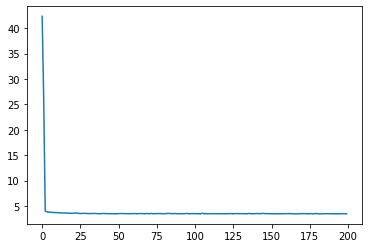

<IPython.core.display.Javascript object>

In [192]:
plt.plot(history.history["RMSE"])

In [94]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 4.778 (0.000)
MAE: 3.826 (0.000)
MAPE: 0.072 (0.000)
R2: 0.569 (0.000)


******
[TEST]
******
RMSE: 3.459 (0.000)
MAE: 2.663 (0.000)
MAPE: 0.051 (0.000)
R2: 0.181 (0.000)




<IPython.core.display.Javascript object>

# Intercement

In [201]:
df = pd.read_csv("../../../../data/processed/Intercement/cement-shipping.csv")
df_no_cs = df.drop(
    [
        "RC1",
        "RC3",
        "RC7",
    ],
    axis=1,
).copy()

y = df_no_cs.pop("RC28")
x = df_no_cs.drop(["Data"], axis=1)
x.columns = x.columns.str.lower()
x = x[COMMON_FEATURES]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [257]:
df

,Data,RC3,RC7,RC28,AL2O3,CAOT,K2O,MGO,SIO2,FE2O3,SO3,P2O5,RC1,COD_PROD_CPIIF40
0,2008-01-02,26.3,34.5,50.1,3.68,55.83,0.28,6.17,17.29,4.34,2.75,0.85,-100.0,0
1,2008-01-02,15.9,24.8,43.9,4.37,53.04,0.28,6.04,18.35,4.22,2.86,0.75,-100.0,0
2,2008-01-03,17.6,26.0,43.7,4.38,53.13,0.28,6.20,18.42,4.37,2.91,0.76,-100.0,0
3,2008-01-03,24.4,31.9,46.5,3.63,56.17,0.27,6.26,17.44,4.56,2.82,0.89,-100.0,0
4,2008-01-04,33.8,37.2,46.8,4.47,59.11,0.81,5.33,17.60,2.31,3.25,0.09,-100.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5556,2019-07-26,27.9,38.3,54.8,3.57,58.71,0.10,6.19,16.44,3.86,2.83,0.86,12.4,1
5557,2019-07-29,27.3,36.4,49.8,3.79,58.78,0.41,5.70,16.86,3.90,2.69,0.99,13.0,1
5558,2019-07-30,17.0,25.2,39.3,3.93,58.69,0.10,5.82,14.65,2.92,3.11,0.80,-100.0,0
5559,2019-07-30,26.1,36.5,50.0,4.09,58.27,0.10,6.09,16.25,3.87,2.69,0.99,13.6,1


<IPython.core.display.Javascript object>

In [206]:
set_seeds()

model_2 = get_model(include_top=False, shape=(x.shape[-1]))
model_2.load_weights("conv1d_weights.h5", by_name=True)
model_2.trainable = False

flat1 = tf.keras.layers.Flatten()(model_2.layers[-1].output)
class1 = tf.keras.layers.Dense(32, activation="relu")(flat1)
class1 = tf.keras.layers.Dense(16, activation="relu")(class1)
outputs = tf.keras.layers.Dense(1, activation="linear")(class1)
model = tf.keras.Model(model_2.inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [207]:
# sc = StandardScaler()

history = model.fit(
    sc.transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

Epoch 1/200
139/139 [==============================] - 0s 1ms/step - loss: 1969.0767 - RMSE: 44.3743
Epoch 2/200
139/139 [==============================] - 0s 1ms/step - loss: 1015.4890 - RMSE: 31.8667
Epoch 3/200
139/139 [==============================] - 0s 1ms/step - loss: 102.0438 - RMSE: 10.1017
Epoch 4/200
139/139 [==============================] - 0s 1ms/step - loss: 33.3711 - RMSE: 5.7768
Epoch 5/200
139/139 [==============================] - 0s 1ms/step - loss: 31.6508 - RMSE: 5.6259
Epoch 6/200
139/139 [==============================] - 0s 1ms/step - loss: 30.2810 - RMSE: 5.5028
Epoch 7/200
139/139 [==============================] - 0s 1ms/step - loss: 29.0677 - RMSE: 5.3914
Epoch 8/200
139/139 [==============================] - 0s 1ms/step - loss: 27.6683 - RMSE: 5.2601
Epoch 9/200
139/139 [==============================] - 0s 1ms/step - loss: 26.2880 - RMSE: 5.1272
Epoch 10/200
139/139 [==============================] - 0s 1ms/step - loss: 24.7724 - RMSE: 4.9772
Epoch 11/20

139/139 [==============================] - 0s 771us/step - loss: 12.7161 - RMSE: 3.5660
Epoch 84/200
139/139 [==============================] - 0s 785us/step - loss: 12.7867 - RMSE: 3.5758
Epoch 85/200
139/139 [==============================] - 0s 793us/step - loss: 12.6691 - RMSE: 3.5594
Epoch 86/200
139/139 [==============================] - 0s 765us/step - loss: 12.6064 - RMSE: 3.5506
Epoch 87/200
139/139 [==============================] - 0s 793us/step - loss: 12.7007 - RMSE: 3.5638
Epoch 88/200
139/139 [==============================] - 0s 905us/step - loss: 12.7276 - RMSE: 3.5676
Epoch 89/200
139/139 [==============================] - 0s 2ms/step - loss: 12.6768 - RMSE: 3.5604
Epoch 90/200
139/139 [==============================] - 0s 2ms/step - loss: 12.7313 - RMSE: 3.5681
Epoch 91/200
139/139 [==============================] - 0s 824us/step - loss: 12.6136 - RMSE: 3.5516
Epoch 92/200
139/139 [==============================] - 0s 812us/step - loss: 12.5163 - RMSE: 3.5378
Epoch 9

139/139 [==============================] - 0s 3ms/step - loss: 12.3687 - RMSE: 3.5169
Epoch 165/200
139/139 [==============================] - 0s 3ms/step - loss: 12.3231 - RMSE: 3.5104
Epoch 166/200
139/139 [==============================] - 0s 3ms/step - loss: 12.2340 - RMSE: 3.4977
Epoch 167/200
139/139 [==============================] - 0s 2ms/step - loss: 12.3686 - RMSE: 3.5169
Epoch 168/200
139/139 [==============================] - 0s 2ms/step - loss: 12.2615 - RMSE: 3.5016
Epoch 169/200
139/139 [==============================] - 0s 3ms/step - loss: 12.1762 - RMSE: 3.4894
Epoch 170/200
139/139 [==============================] - 0s 2ms/step - loss: 12.2853 - RMSE: 3.5050
Epoch 171/200
139/139 [==============================] - 0s 2ms/step - loss: 12.3875 - RMSE: 3.5196
Epoch 172/200
139/139 [==============================] - 0s 1ms/step - loss: 12.1543 - RMSE: 3.4863
Epoch 173/200
139/139 [==============================] - 0s 2ms/step - loss: 12.4383 - RMSE: 3.5268
Epoch 174/200


<IPython.core.display.Javascript object>

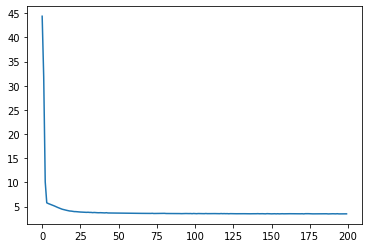

<IPython.core.display.Javascript object>

In [208]:
plt.plot(history.history["RMSE"])

In [209]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 3.458 (0.000)
MAE: 2.628 (0.000)
MAPE: 0.058 (0.000)
R2: 0.711 (0.000)


******
[TEST]
******
RMSE: 7.336 (0.000)
MAE: 6.035 (0.000)
MAPE: 0.111 (0.000)
R2: 0.589 (0.000)




<IPython.core.display.Javascript object>

# Experiments with Same Variables

In [211]:
df_intercement = pd.read_csv(
    "../../../../data/processed/Intercement/cement-shipping.csv"
)
df_partner_ii = pd.read_csv("../../../../data/processed/partner_ii/cement-shipping.csv")
df_partner_i = pd.read_csv(
    "../../../../data/processed/partner_i-Oficial/cement-shipping.csv"
)

<IPython.core.display.Javascript object>

In [212]:
set(df_intercement.columns.str.lower()).intersection(
    set(df_partner_ii.columns.str.lower())
)

{'al2o3', 'fe2o3', 'k2o', 'mgo', 'sio2', 'so3'}

<IPython.core.display.Javascript object>

In [213]:
set(df_intercement.columns.str.lower()).intersection(
    set(df_partner_i.columns.str.lower())
)

{'al2o3', 'fe2o3', 'k2o', 'mgo', 'sio2', 'so3'}

<IPython.core.display.Javascript object>

In [214]:
set(df_partner_ii.columns.str.lower()).intersection(
    set(df_partner_i.columns.str.lower())
)

{'al2o3',
 'aluminate',
 'cao',
 'fe2o3',
 'ferrite',
 'k2o',
 'mgo',
 'na2o',
 'sio2',
 'so3'}

<IPython.core.display.Javascript object>

# Baseline Model

# Linear Regression

In [215]:
COMMON_FEATURES = [
    "cao",
    "sio2",
    "al2o3",
    "fe2o3",
    "aluminate",
    "na2o",
    "mgo",
    "so3",
    "ferrite",
    "k2o",
]

<IPython.core.display.Javascript object>

# partner_ii

In [218]:
df_partner_ii = pd.read_csv("../../../../data/processed/partner_ii/cement-shipping.csv")
df_no_cs = df_partner_ii.drop(
    ["strength_1d", "strength_3d", "strength_7d"],
    axis=1,
).copy()
y = df_no_cs.pop("strength_28d")
x = df_no_cs.rename({"sample_date": "date"}, axis=1)

x.columns = x.columns.str.lower()
x = x[COMMON_FEATURES]

<IPython.core.display.Javascript object>

In [219]:
repeats = 10
n_splits = 10
set_seeds()
pipeline = Pipeline(
    [("transformer", StandardScaler()), ("estimator", LinearRegression())]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
# scores = np.abs(scores)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

Repeated Cross Validation:
Repeats: 10
n_splits: 10

******
[TRAIN]
******
RMSE: 2.708 (0.023)
MAE: 2.159 (0.018)
MAPE: 0.050 (0.000)
R2: 0.413 (0.009)


******
[TEST]
******
RMSE: 2.764 (0.231)
MAE: 2.190 (0.156)
MAPE: 0.051 (0.004)
R2: 0.375 (0.104)




<IPython.core.display.Javascript object>

# Pre Trainning

# partner_i

In [107]:
batch_size = 32
epochs = 200
verbose = 1

<IPython.core.display.Javascript object>

In [108]:
COMMON_FEATURES = [
    "cao",
    "sio2",
    "al2o3",
    "fe2o3",
    "aluminate",
    "na2o",
    "mgo",
    "so3",
    "ferrite",
    "k2o",
]

<IPython.core.display.Javascript object>

In [220]:
df_partner_i = pd.read_csv(
    "../../../../data/processed/partner_i-Oficial/cement-shipping.csv"
)

<IPython.core.display.Javascript object>

In [221]:
df_partner_i = df_partner_i.drop(
    [
        "1 day Compressive strength",
        "3 day Compressive strength",
        "7 day Compressive strength",
    ],
    axis=1,
).copy()

y = df_partner_i.pop("28 day Compressive strength")
x = df_partner_i.drop(["Date"], axis=1)
x.columns = x.columns.str.lower()
x = x[COMMON_FEATURES]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [222]:
set_seeds()
model = get_model(shape=(x_train.shape[-1]))
sc = StandardScaler()

history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

Epoch 1/200
31/31 [==============================] - 0s 1ms/step - loss: 1871.0724 - RMSE: 43.2559
Epoch 2/200
31/31 [==============================] - 0s 2ms/step - loss: 1800.9491 - RMSE: 42.4376
Epoch 3/200
31/31 [==============================] - 0s 2ms/step - loss: 1674.8539 - RMSE: 40.9250
Epoch 4/200
31/31 [==============================] - 0s 2ms/step - loss: 1463.4191 - RMSE: 38.2547
Epoch 5/200
31/31 [==============================] - 0s 2ms/step - loss: 1140.9330 - RMSE: 33.7777
Epoch 6/200
31/31 [==============================] - 0s 2ms/step - loss: 719.6006 - RMSE: 26.8254
Epoch 7/200
31/31 [==============================] - 0s 2ms/step - loss: 334.0667 - RMSE: 18.2775
Epoch 8/200
31/31 [==============================] - 0s 2ms/step - loss: 118.7027 - RMSE: 10.8951
Epoch 9/200
31/31 [==============================] - 0s 2ms/step - loss: 57.9748 - RMSE: 7.6141
Epoch 10/200
31/31 [==============================] - 0s 2ms/step - loss: 49.9634 - RMSE: 7.0685
Epoch 11/200
31/31

31/31 [==============================] - 0s 3ms/step - loss: 31.7679 - RMSE: 5.6363
Epoch 86/200
31/31 [==============================] - 0s 3ms/step - loss: 32.8361 - RMSE: 5.7303
Epoch 87/200
31/31 [==============================] - 0s 2ms/step - loss: 33.2445 - RMSE: 5.7658
Epoch 88/200
31/31 [==============================] - 0s 2ms/step - loss: 31.2931 - RMSE: 5.5940
Epoch 89/200
31/31 [==============================] - 0s 2ms/step - loss: 34.3905 - RMSE: 5.8643
Epoch 90/200
31/31 [==============================] - 0s 2ms/step - loss: 34.5654 - RMSE: 5.8792
Epoch 91/200
31/31 [==============================] - 0s 2ms/step - loss: 32.1778 - RMSE: 5.6725
Epoch 92/200
31/31 [==============================] - 0s 2ms/step - loss: 30.2343 - RMSE: 5.4986
Epoch 93/200
31/31 [==============================] - 0s 3ms/step - loss: 32.1305 - RMSE: 5.6684
Epoch 94/200
31/31 [==============================] - 0s 2ms/step - loss: 33.1695 - RMSE: 5.7593
Epoch 95/200
31/31 [=======================

31/31 [==============================] - 0s 1ms/step - loss: 32.0951 - RMSE: 5.6653
Epoch 169/200
31/31 [==============================] - 0s 2ms/step - loss: 29.3351 - RMSE: 5.4162
Epoch 170/200
31/31 [==============================] - 0s 1ms/step - loss: 30.2796 - RMSE: 5.5027
Epoch 171/200
31/31 [==============================] - 0s 1ms/step - loss: 30.4289 - RMSE: 5.5162
Epoch 172/200
31/31 [==============================] - 0s 882us/step - loss: 35.1191 - RMSE: 5.9261
Epoch 173/200
31/31 [==============================] - 0s 1ms/step - loss: 30.8969 - RMSE: 5.5585
Epoch 174/200
31/31 [==============================] - 0s 2ms/step - loss: 29.9407 - RMSE: 5.4718
Epoch 175/200
31/31 [==============================] - 0s 2ms/step - loss: 33.4087 - RMSE: 5.7800
Epoch 176/200
31/31 [==============================] - 0s 2ms/step - loss: 32.4407 - RMSE: 5.6957
Epoch 177/200
31/31 [==============================] - 0s 2ms/step - loss: 32.4160 - RMSE: 5.6935
Epoch 178/200
31/31 [===========

<IPython.core.display.Javascript object>

In [223]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))
scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 3.582 (0.000)
MAE: 2.838 (0.000)
MAPE: 0.068 (0.000)
R2: 0.497 (0.000)


******
[TEST]
******
RMSE: 3.448 (0.000)
MAE: 2.789 (0.000)
MAPE: 0.064 (0.000)
R2: 0.519 (0.000)




<IPython.core.display.Javascript object>

In [224]:
model.save_weights("conv1d_weights.h5")

<IPython.core.display.Javascript object>

# Fine Tuning

# partner_ii

In [225]:
df_partner_ii = pd.read_csv("../../../../data/processed/partner_ii/cement-shipping.csv")
df_no_cs = df_partner_ii.drop(
    ["strength_1d", "strength_3d", "strength_7d"],
    axis=1,
).copy()
y = df_no_cs.pop("strength_28d")
x = df_no_cs.rename({"sample_date": "date"}, axis=1)

x.columns = x.columns.str.lower()
x = x[COMMON_FEATURES]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [226]:
set_seeds()
model_2 = get_model(include_top=False, shape=(x.shape[-1]))
model_2.load_weights("conv1d_weights.h5", by_name=True)
model_2.trainable = True

flat1 = tf.keras.layers.Flatten()(model_2.layers[-1].output)
class1 = tf.keras.layers.Dense(32, activation="relu")(flat1)
class1 = tf.keras.layers.Dense(16, activation="relu")(class1)
outputs = tf.keras.layers.Dense(1, activation="linear")(class1)
model = tf.keras.Model(model_2.inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [227]:
#sc = StandardScaler()

history = model.fit(
    sc.transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)


Epoch 1/200
27/27 [==============================] - 0s 1ms/step - loss: 1893.4406 - RMSE: 43.5137
Epoch 2/200
27/27 [==============================] - 0s 2ms/step - loss: 1757.3881 - RMSE: 41.9212
Epoch 3/200
27/27 [==============================] - 0s 1ms/step - loss: 1358.6794 - RMSE: 36.8603
Epoch 4/200
27/27 [==============================] - 0s 2ms/step - loss: 528.7844 - RMSE: 22.9953
Epoch 5/200
27/27 [==============================] - 0s 2ms/step - loss: 25.9144 - RMSE: 5.0906
Epoch 6/200
27/27 [==============================] - 0s 2ms/step - loss: 11.1337 - RMSE: 3.3367
Epoch 7/200
27/27 [==============================] - 0s 2ms/step - loss: 10.2081 - RMSE: 3.1950
Epoch 8/200
27/27 [==============================] - 0s 2ms/step - loss: 9.8954 - RMSE: 3.1457
Epoch 9/200
27/27 [==============================] - 0s 2ms/step - loss: 9.7708 - RMSE: 3.1258
Epoch 10/200
27/27 [==============================] - 0s 2ms/step - loss: 9.6981 - RMSE: 3.1142
Epoch 11/200
27/27 [===========

27/27 [==============================] - 0s 3ms/step - loss: 6.6514 - RMSE: 2.5790
Epoch 87/200
27/27 [==============================] - 0s 2ms/step - loss: 6.6260 - RMSE: 2.5741
Epoch 88/200
27/27 [==============================] - 0s 2ms/step - loss: 6.6613 - RMSE: 2.5809
Epoch 89/200
27/27 [==============================] - 0s 2ms/step - loss: 6.6032 - RMSE: 2.5697
Epoch 90/200
27/27 [==============================] - 0s 2ms/step - loss: 6.6234 - RMSE: 2.5736
Epoch 91/200
27/27 [==============================] - 0s 2ms/step - loss: 6.6163 - RMSE: 2.5722
Epoch 92/200
27/27 [==============================] - 0s 2ms/step - loss: 6.6763 - RMSE: 2.5839
Epoch 93/200
27/27 [==============================] - 0s 2ms/step - loss: 6.6124 - RMSE: 2.5715
Epoch 94/200
27/27 [==============================] - 0s 2ms/step - loss: 6.7017 - RMSE: 2.5888
Epoch 95/200
27/27 [==============================] - 0s 2ms/step - loss: 6.6443 - RMSE: 2.5777
Epoch 96/200
27/27 [==============================] -

27/27 [==============================] - 0s 2ms/step - loss: 6.4783 - RMSE: 2.5452
Epoch 171/200
27/27 [==============================] - 0s 2ms/step - loss: 6.3712 - RMSE: 2.5241
Epoch 172/200
27/27 [==============================] - 0s 3ms/step - loss: 6.3579 - RMSE: 2.5215
Epoch 173/200
27/27 [==============================] - 0s 3ms/step - loss: 6.3395 - RMSE: 2.5178
Epoch 174/200
27/27 [==============================] - 0s 2ms/step - loss: 6.2152 - RMSE: 2.4930
Epoch 175/200
27/27 [==============================] - 0s 2ms/step - loss: 6.3627 - RMSE: 2.5224
Epoch 176/200
27/27 [==============================] - 0s 3ms/step - loss: 6.6115 - RMSE: 2.5713
Epoch 177/200
27/27 [==============================] - 0s 3ms/step - loss: 6.7992 - RMSE: 2.6075
Epoch 178/200
27/27 [==============================] - 0s 3ms/step - loss: 6.3460 - RMSE: 2.5191
Epoch 179/200
27/27 [==============================] - 0s 3ms/step - loss: 6.3604 - RMSE: 2.5220
Epoch 180/200
27/27 [=======================

<IPython.core.display.Javascript object>

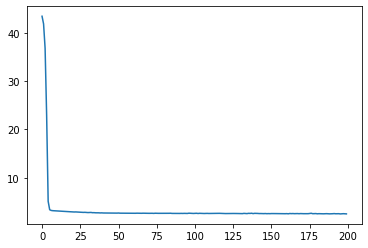

<IPython.core.display.Javascript object>

In [228]:
plt.plot(history.history["RMSE"])

In [229]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 2.492 (0.000)
MAE: 1.994 (0.000)
MAPE: 0.045 (0.000)
R2: 0.417 (0.000)


******
[TEST]
******
RMSE: 3.998 (0.000)
MAE: 3.386 (0.000)
MAPE: 0.087 (0.000)
R2: 1.061 (0.000)




<IPython.core.display.Javascript object>

# Pre Trainning

# partner_i + Intercement

In [232]:
batch_size = 32
epochs = 200
verbose = 0

<IPython.core.display.Javascript object>

In [233]:
COMMON_FEATURES = ["mgo", "al2o3", "sio2", "so3", "k2o", "fe2o3"]

<IPython.core.display.Javascript object>

In [234]:
df = pd.read_csv("../../../../data/processed/Intercement/cement-shipping.csv")
df_no_cs = df.drop(
    [
        "RC1",
        "RC3",
        "RC7",
    ],
    axis=1,
).copy()
y_1 = df_no_cs.pop("RC28")
x_1 = df_no_cs.rename({"Data": "date"}, axis=1)
x_1.columns = x_1.columns.str.lower()

df_partner_i = pd.read_csv(
    "../../../../data/processed/partner_i-Oficial/cement-shipping.csv"
)
df_partner_i = df_partner_i.drop(
    [
        "1 day Compressive strength",
        "3 day Compressive strength",
        "7 day Compressive strength",
    ],
    axis=1,
).copy()

y_2 = df_partner_i.pop("28 day Compressive strength")
x_2 = df_partner_i

x_2.columns = x_2.columns.str.lower()
x_2 = x_2.drop(set(x_2.columns) - set(x_1.columns), axis=1)
x_1 = x_1[x_2.columns]


y_1.name = "cs28"
y_2.name = "cs28"

x = pd.concat([x_1, x_2], axis=0).reset_index(drop=True)
y = pd.concat([y_1, y_2], axis=0).reset_index(drop=True)

x = pd.concat([x, y], axis=1)
x["date"] = x["date"].apply(lambda x: x[:10])
x["date"] = pd.to_datetime(x["date"])
x = x.sort_values(by="date").reset_index(drop=True)
y = x.pop("cs28")
x.columns = x.columns.str.lower()
x = x[COMMON_FEATURES]


x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [235]:
set_seeds()

model = get_model(shape=x_train.shape[-1], include_top=True)
sc = StandardScaler()

history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

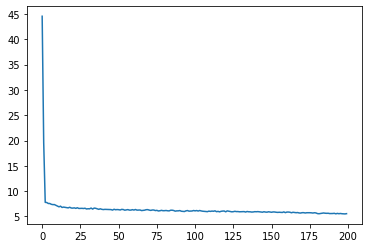

<IPython.core.display.Javascript object>

In [236]:
plt.plot(history.history["RMSE"])

In [237]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))
scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 4.092 (0.000)
MAE: 3.164 (0.000)
MAPE: 0.068 (0.000)
R2: 0.652 (0.000)


******
[TEST]
******
RMSE: 11.015 (0.000)
MAE: 9.655 (0.000)
MAPE: 0.236 (0.000)
R2: 2.945 (0.000)




<IPython.core.display.Javascript object>

In [238]:
model.save_weights("conv1d_weights.h5")

<IPython.core.display.Javascript object>

# Fine Tuning

# partner_ii

In [239]:
df_partner_ii = pd.read_csv("../../../../data/processed/partner_ii/cement-shipping.csv")
df_no_cs = df_partner_ii.drop(
    ["strength_1d", "strength_3d", "strength_7d"],
    axis=1,
).copy()
y = df_no_cs.pop("strength_28d")
x = df_no_cs.rename({"sample_date": "date"}, axis=1)

x.columns = x.columns.str.lower()
x = x[COMMON_FEATURES]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [240]:
set_seeds()
model_2 = get_model(include_top=False, shape=(x.shape[-1]))
model_2.load_weights("conv1d_weights.h5", by_name=True)
model_2.trainable = True

flat1 = tf.keras.layers.Flatten()(model_2.layers[-1].output)
class1 = tf.keras.layers.Dense(256, activation="relu")(flat1)
class1 = tf.keras.layers.Dense(128, activation="relu")(class1)
class1 = tf.keras.layers.Dense(64, activation="relu")(class1)
outputs = tf.keras.layers.Dense(1, activation="linear")(class1)
model = tf.keras.Model(model_2.inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [241]:
#sc = StandardScaler()

history = model.fit(
    sc.transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)


<IPython.core.display.Javascript object>

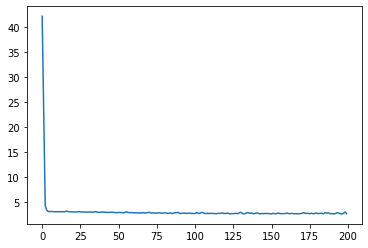

<IPython.core.display.Javascript object>

In [242]:
plt.plot(history.history["RMSE"])

In [243]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 2.636 (0.000)
MAE: 2.120 (0.000)
MAPE: 0.048 (0.000)
R2: 0.347 (0.000)


******
[TEST]
******
RMSE: 4.077 (0.000)
MAE: 3.545 (0.000)
MAPE: 0.092 (0.000)
R2: 1.143 (0.000)




<IPython.core.display.Javascript object>

# Pre Trainning

# partner_i

In [244]:
batch_size = 32
epochs = 200
verbose = 0

<IPython.core.display.Javascript object>

In [245]:
COMMON_FEATURES_partner_i = ["%limestone", "%gypsum", "%clinker"]

<IPython.core.display.Javascript object>

In [246]:
df_partner_i = pd.read_csv(
    "../../../../data/processed/partner_i-Oficial/cement-shipping.csv"
)
df_partner_i = df_partner_i.drop(
    [
        "1 day Compressive strength",
        "3 day Compressive strength",
        "7 day Compressive strength",
    ],
    axis=1,
).copy()

y = df_partner_i.pop("28 day Compressive strength")
df_partner_i.columns = df_partner_i.columns.str.lower()
x = df_partner_i[COMMON_FEATURES_partner_i]


x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [247]:
set_seeds()

model = get_model(shape=x_train.shape[-1], include_top=True)
sc = StandardScaler()

history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

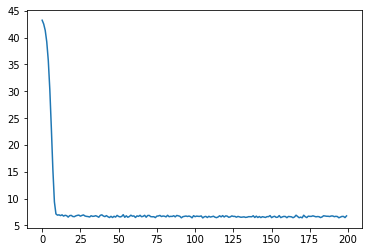

<IPython.core.display.Javascript object>

In [248]:
plt.plot(history.history["RMSE"])

In [249]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))
scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 5.059 (0.000)
MAE: 4.733 (0.000)
MAPE: 0.113 (0.000)
R2: 0.004 (0.000)


******
[TEST]
******
RMSE: 5.123 (0.000)
MAE: 4.940 (0.000)
MAPE: 0.116 (0.000)
R2: 0.063 (0.000)




<IPython.core.display.Javascript object>

In [250]:
model.save_weights("conv1d_weights.h5")

<IPython.core.display.Javascript object>

# Fine Tuning

# partner_iii

In [251]:
df_partner_iii = pd.read_csv(
    "../../../../data/interim/partner_iii/Dati CADD 2020-2022_with_fillna.csv"
)

<IPython.core.display.Javascript object>

In [252]:
y = df_partner_iii.pop("28d compressive strength (MPa)")
x = df_partner_iii

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [253]:
set_seeds()

model_2 = get_model(include_top=False, shape=(x.shape[-1]))
model_2.load_weights("conv1d_weights.h5", by_name=True)
model_2.trainable = True

flat1 = tf.keras.layers.Flatten(name="Flatten2")(model_2.layers[-1].output)
class1 = tf.keras.layers.Dense(256, activation="relu")(flat1)
outputs = tf.keras.layers.Dense(1, activation="linear")(class1)
model = tf.keras.Model(model_2.inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [254]:
# c = StandardScaler()
history = model.fit(
    sc.transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

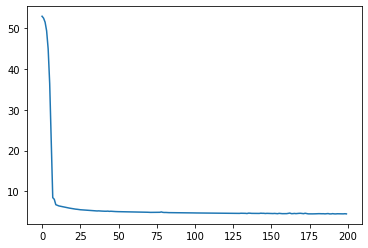

<IPython.core.display.Javascript object>

In [255]:
plt.plot(history.history["RMSE"])

In [256]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 4.404 (0.000)
MAE: 3.421 (0.000)
MAPE: 0.066 (0.000)
R2: 0.634 (0.000)


******
[TEST]
******
RMSE: 3.883 (0.000)
MAE: 2.713 (0.000)
MAPE: 0.054 (0.000)
R2: 0.032 (0.000)




<IPython.core.display.Javascript object>

# partner_iii

In [144]:
df_partner_iii = pd.read_csv(
    "../../../data/interim/partner_iii/Dati CADD 2020-2022_with_fillna.csv"
)

<IPython.core.display.Javascript object>

In [145]:
y = df_partner_iii.pop("28d compressive strength (MPa)")
x = df_partner_iii

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [146]:
set_seeds()
model = get_model(include_top=True, shape=(x.shape[-1]))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [147]:
sc = StandardScaler()
history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

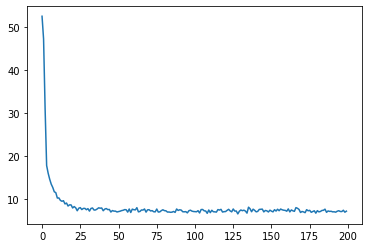

<IPython.core.display.Javascript object>

In [148]:
plt.plot(history.history["RMSE"])

In [149]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 4.134 (0.000)
MAE: 3.169 (0.000)
MAPE: 0.061 (0.000)
R2: 0.678 (0.000)


******
[TEST]
******
RMSE: 4.282 (0.000)
MAE: 3.113 (0.000)
MAPE: 0.062 (0.000)
R2: 0.255 (0.000)




<IPython.core.display.Javascript object>

## CPIIF40

# Intercement

In [259]:
df = pd.read_csv("../../../../data/processed/Intercement/cpiif40.csv")

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered.

In [260]:
df_no_cs = df.drop(
    [
        "RC1",
        "RC3",
        "RC7",
    ],
    axis=1,
).copy()

y = df_no_cs.pop("RC28").values
x = df_no_cs.drop(["Data"], axis=1)

<IPython.core.display.Javascript object>

## 1.1 Repeated KFold Cross validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Repeats:</b>10<br>
<b>Splits:</b>10<br>
    1. 10 folds of 123 samples each
    2. 90% train (1111 samples each fold)
    3. 10% test (123 samples each fold)
<b>Total:</b> 100 models<br>

In [261]:
set_seeds()
repeats = 10
n_splits = 10
pipeline = Pipeline(
    [("transformer", StandardScaler()), ("estimator", LinearRegression())]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
# scores = np.abs(scores)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

Repeated Cross Validation:
Repeats: 10
n_splits: 10

******
[TRAIN]
******
RMSE: 2.613 (0.020)
MAE: 2.074 (0.014)
MAPE: 0.038 (0.000)
R2: 0.245 (0.011)


******
[TEST]
******
RMSE: 2.678 (0.226)
MAE: 2.098 (0.108)
MAPE: 0.039 (0.002)
R2: 0.195 (0.144)




<IPython.core.display.Javascript object>

In [262]:
df.shape

(1787, 13)

<IPython.core.display.Javascript object>

In [271]:
df_partner_i = pd.read_csv("../../../../data/processed/partner_i-Oficial/cpiif40.csv")

df_partner_i = df_partner_i.drop(
    [
        "1 day Compressive strength",
        "3 day Compressive strength",
        "7 day Compressive strength",
    ],
    axis=1,
).copy()

y = df_partner_i.pop("28 day Compressive strength")
x = df_partner_i.drop(["Date"], axis=1)
x.columns = x.columns.str.lower()
x = x[COMMON_FEATURES]

<IPython.core.display.Javascript object>

In [272]:
set_seeds()
repeats = 10
n_splits = 10
pipeline = Pipeline(
    [("transformer", StandardScaler()), ("estimator", LinearRegression())]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
# scores = np.abs(scores)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

Repeated Cross Validation:
Repeats: 10
n_splits: 10

******
[TRAIN]
******
RMSE: 1.138 (0.012)
MAE: 0.885 (0.011)
MAPE: 0.019 (0.000)
R2: 0.071 (0.007)


******
[TEST]
******
RMSE: 1.465 (1.433)
MAE: 0.949 (0.228)
MAPE: 0.020 (0.005)
R2: 2.415 (16.473)




<IPython.core.display.Javascript object>

# Pre Trainning

# partner_i

In [297]:
batch_size = 32
epochs = 200
verbose = 0

<IPython.core.display.Javascript object>

In [298]:
COMMON_FEATURES = ["mgo", "al2o3", "sio2", "so3", "k2o", "fe2o3"]

<IPython.core.display.Javascript object>

In [299]:
df_partner_i = pd.read_csv("../../../../data/processed/partner_i-Oficial/cpiif40.csv")

<IPython.core.display.Javascript object>

In [300]:
df_partner_i = df_partner_i.drop(
    [
        "1 day Compressive strength",
        "3 day Compressive strength",
        "7 day Compressive strength",
    ],
    axis=1,
).copy()

y = df_partner_i.pop("28 day Compressive strength")
x = df_partner_i.drop(["Date"], axis=1)
x.columns = x.columns.str.lower()
x = x[COMMON_FEATURES]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [301]:
set_seeds()

model = get_model(shape=(x_train.shape[-1]))
sc = StandardScaler()

history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

In [302]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 1.281 (0.000)
MAE: 0.963 (0.000)
MAPE: 0.020 (0.000)
R2: 0.245 (0.000)


******
[TEST]
******
RMSE: 1.584 (0.000)
MAE: 1.224 (0.000)
MAPE: 0.025 (0.000)
R2: 0.501 (0.000)




<IPython.core.display.Javascript object>

In [303]:
model.save_weights("conv1d_weights.h5")

<IPython.core.display.Javascript object>

# Intercement

In [316]:
df = pd.read_csv("../../../../data/processed/Intercement/cpiif40.csv")
df_no_cs = df.drop(
    [
        "RC1",
        "RC3",
        "RC7",
    ],
    axis=1,
).copy()

y = df_no_cs.pop("RC28")
x = df_no_cs.drop(["Data"], axis=1)
x.columns = x.columns.str.lower()
x = x[COMMON_FEATURES]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [322]:
set_seeds()

model_2 = get_model(include_top=False, shape=(x.shape[-1]))
model_2.load_weights("conv1d_weights.h5", by_name=True)
model_2.trainable = False

flat1 = tf.keras.layers.Flatten()(model_2.layers[-1].output)
class1 = tf.keras.layers.Dense(256, activation="relu")(flat1)
# class1 = tf.keras.layers.Dense(16, activation="relu")(class1)
outputs = tf.keras.layers.Dense(1, activation="linear")(class1)
model = tf.keras.Model(model_2.inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    # loss=tf.keras.losses.Huber(),
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [323]:
# sc = StandardScaler()

history = model.fit(
    sc.transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

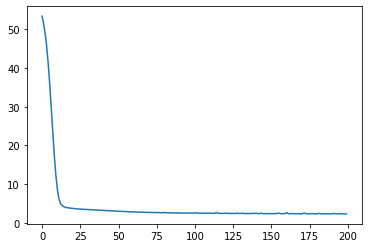

<IPython.core.display.Javascript object>

In [324]:
plt.plot(history.history["RMSE"])

In [325]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 2.349 (0.000)
MAE: 1.882 (0.000)
MAPE: 0.035 (0.000)
R2: 0.165 (0.000)


******
[TEST]
******
RMSE: 7.080 (0.000)
MAE: 5.805 (0.000)
MAPE: 0.100 (0.000)
R2: 5.533 (0.000)




<IPython.core.display.Javascript object>